# Import

In [1]:
import os
import struct
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.tensorboard import SummaryWriter
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)


# Utility functions

## Data load functions

In [2]:
def load_mnist(path, kind="train"):
    """
    Documentation:

        ---
        Description:
            Load MNIST images and labels from unzipped source files.

        ---
        Parameters:
            kind : str
                Used to identify training data vs. validation data. Pass
                "train" to load training data, and "t10k" to load validation
                data.
                
        ---
        Returns
            images : Numpy array
                Numpy array containing all images in dataset. Has shape N by
                784, where N is the number of samples and 784 is the number
                of pixels.
            targets : Numpy array
                Numpy array containing all targets associated with images.
                Has shape N by 1, where N is the number of samples.
    """
    
    labels_path = os.path.join(path,
                               "{}-labels-idx1-ubyte".format(kind))
    images_path = os.path.join(path,
                               "{}-images-idx3-ubyte".format(kind))
    
    with open(labels_path, "rb") as lbpath:
        magic, n = struct.unpack(">II",
                                 lbpath.read(8))
        targets = np.fromfile(lbpath,
                             dtype=np.uint8)
    
    with open(images_path, "rb") as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII",
                                               imgpath.read(16))
        images = np.fromfile(imgpath,
                             dtype=np.uint8).reshape(
                             len(targets), 784)
    
    return images, targets

class MNISTDataset(Dataset):
    """
    Documentation:

        ---
        Description:
            Load MNIST images and labels into a Pytorch Dataset.

        ---
        Parameters:
            images : Numpy array
                Numpy array containing all images in dataset. Has shape N by
                784, where N is the number of samples and 784 is the number
                of pixels.
            targets : Numpy array
                Numpy array containing all targets associated with images.
                Has shape N by 1, where N is the number of samples.
            transform : Pytorch transforms object
                Optional transformation instructions for images
    """
    def __init__(self, images, targets, transform=None):
        self.images = images.reshape(-1,28,28)
        self.targets = targets
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index]
        target = self.targets[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, target

## Imaging functions

In [3]:
def image_sample(inp, figsize=(20,20)):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=figsize)
    plt.imshow(
        inp,
        interpolation="nearest"
    )

In [4]:
# plot sample image
def plot_sample(image):
    plt.imshow(image, cmap="gray")

# Workflow

## Load training data

In [5]:
# load source files
X_train, y_train = load_mnist(
    path=os.path.join(os.environ["HOME"], "s3buckets", "mnist"),
    kind="train"
)

# transformation instructions
norm_mean = [0.1307]
norm_std = [0.3801]

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        norm_mean,
        norm_std
    ),
])

# load data into Pytorch Dataset
train_data = MNISTDataset(
    images=X_train,
    targets=y_train,
    transform=train_transform,
)

# create Pytorch DataLoader
train_data_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=32,
    shuffle=False,
)

### review samples

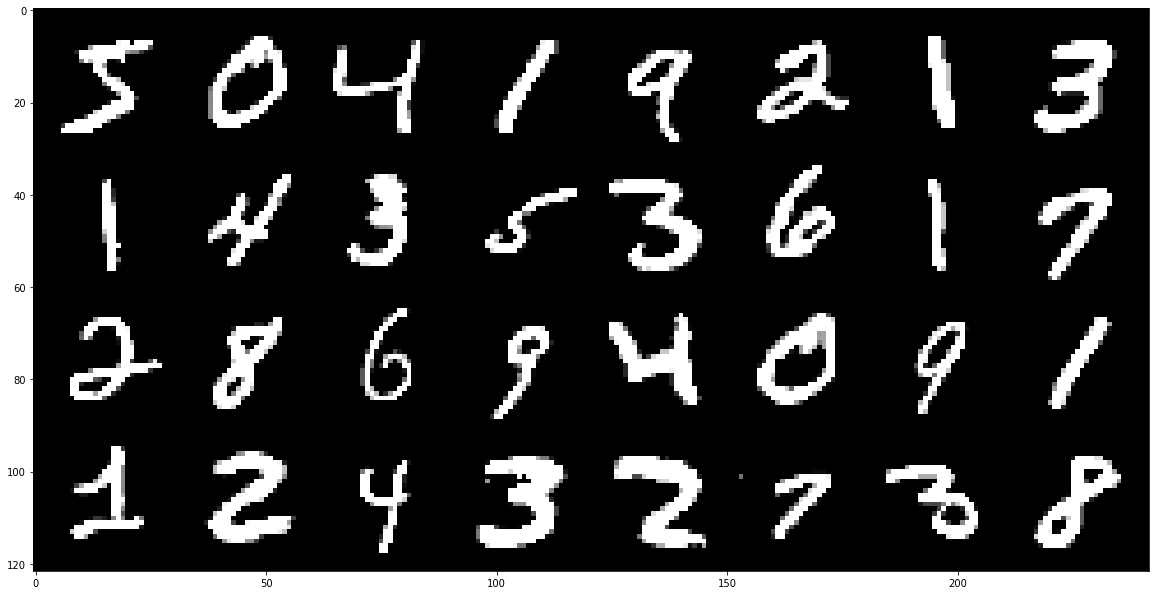

In [6]:
# visualize image batch grid
inputs, classes = next(iter(train_data_loader))
out = torchvision.utils.make_grid(inputs)
image_sample(out)

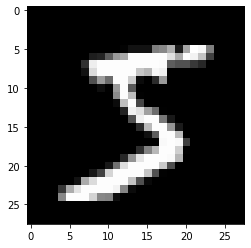

In [7]:
sample = iter(train_data_loader.dataset.images)
plot_sample(next(sample))

## Load validation data

In [8]:
# load source files
X_valid, y_valid = load_mnist(
    path=os.path.join(os.environ["HOME"], "s3buckets", "mnist"),
    kind="t10k"
)

# transformation instructions
norm_mean = [0.1307]
norm_std = [0.3801]

valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        norm_mean,
        norm_std
    )
])

# load data into Pytorch dataset
valid_data = MNISTDataset(
    images=X_valid,
    targets=y_valid,
    transform=valid_transform,
)

# create Pytorch DataLoader
valid_data_loader = torch.utils.data.DataLoader(
    valid_data,
    batch_size=32,
    shuffle=False,
    # sampler=weighted_sampler
)

### Review samples

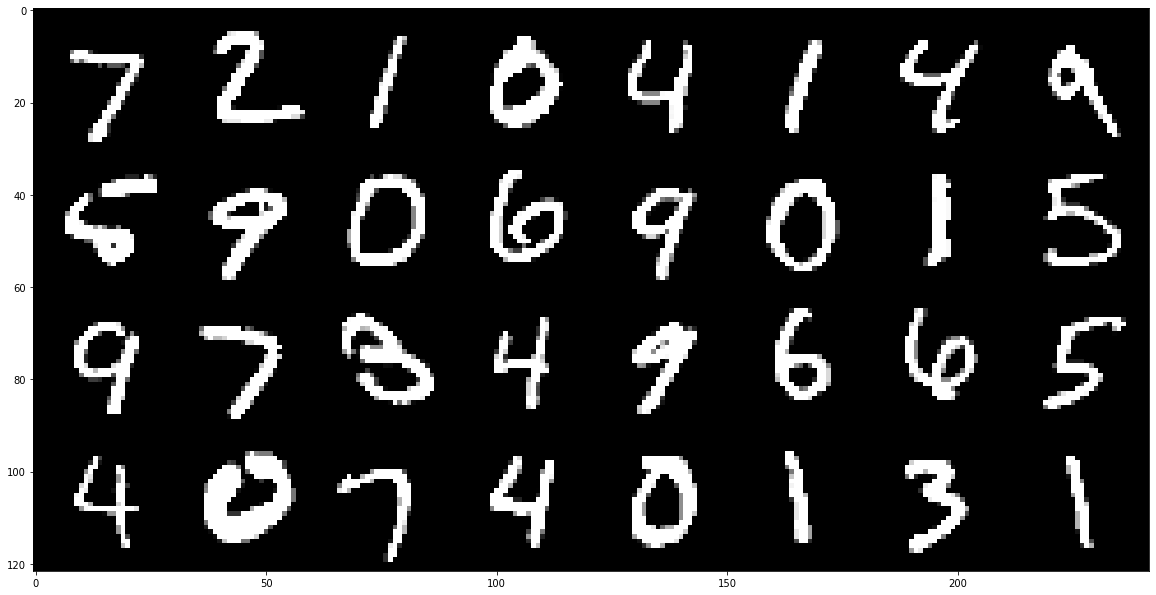

In [9]:
# visualize image batch grid
inputs, classes = next(iter(valid_data_loader))
out = torchvision.utils.make_grid(inputs)

image_sample(out)

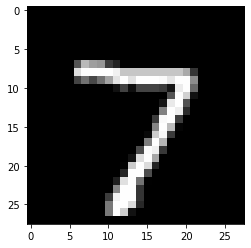

In [10]:
sample = iter(valid_data_loader.dataset.images)
plot_sample(next(sample))

## Model

In [11]:
# set model architecture
class fcNet(nn.Module):
    def __init__(self):
        super(fcNet, self).__init__()
        self.inputLayer = nn.Linear(784, 1024)
        self.fullyConnected1 = nn.Linear(1024, 1024)
        self.fullyConnected2 = nn.Linear(1024, 1024)
        self.fullyConnected3 = nn.Linear(1024, 1024)
        self.fullyConnected4 = nn.Linear(1024, 1024)
        self.fullyConnected5 = nn.Linear(1024, 1024)
        self.outputLayer = nn.Linear(1024, 10)
        
    def forward(self, x):
        x = F.relu(self.inputLayer(x))
        x = F.relu(self.fullyConnected1(x))
        x = F.relu(self.fullyConnected2(x))
        x = F.relu(self.fullyConnected3(x))
        x = F.relu(self.fullyConnected4(x))
        x = F.relu(self.fullyConnected5(x))
        x = F.log_softmax(self.outputLayer(x), dim=1)
        return x

## Training

### Parameter setup

In [13]:
# set input kwargs as object attributes
class ParamConfig:  
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

# configure all necessary parameters
model_params = ParamConfig(
    model = fcNet,
    optimizer = torch.optim.Adam,
    criterion = F.nll_loss,
    train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True),
    valid_data_loader = torch.utils.data.DataLoader(valid_data, batch_size=128, shuffle=True),
    cuda = True if torch.cuda.is_available() else False,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    seed = 0,
    lr = 0.001,
    epochs = 50,
    save_model = True,
    tensorboard_files = False,
)

### Training procedure

In [18]:
class PyTorchTrainer:
    """
    
    """
    def __init__(self, config):
        self.globaliter = 0

        # data loaders
        self.train_data_loader = config.train_data_loader
        self.valid_data_loader = config.valid_data_loader
        
        # random seed settings
        self.seed = config.seed        
        torch.manual_seed(self.seed)
        
        # device settings
        self.cuda = config.cuda
        self.device = config.device
        kwargs = {'num_workers': 1, 'pin_memory': True} if self.cuda else {}

        # model training settings
        self.model = config.model().to(self.device)
        self.lr = config.lr
        self.epochs = config.epochs
        self.optimizer = config.optimizer(self.model.parameters(), lr=self.lr)
        self.criterion = config.criterion

        # save model
        self.save_model = config.save_model

        # tensorboard
        self.tensorboard_files = config.tensorboard_files
        if self.tensorboard_files:
            current = str(datetime.datetime.now().timestamp())
            train_log_fir = "logs/mnist1/train/" + current
            test_log_dir = "logs/mnist1/test/" + current
            self.train_summary_writer = SummaryWriter(train_log_fir)
            self.valid_summary_writer = SummaryWriter(test_log_dir)
        else:
            self.train_summary_writer = None
            self.valid_summary_writer = None

        # statistics
        self.train_loss = []
        self.valid_loss = []
        self.test_accuracy = []

            
    def train(self, epoch):
        # set model to train mode
        self.model.train()
        print("*" * 80)
        
        # iterate through batches
        for batch_idx, (data, target) in enumerate(self.train_data_loader):
            self.globaliter += 1
            
            # reshape data as needed and send data to GPU if available
            data = data.reshape(-1, 28*28).to(self.device).float()
            target = target.to(self.device).long()

            # zero out gradients
            self.optimizer.zero_grad()
            
            # generate predictiona
            preds = self.model(data)

            # calculate loss given current predictions vs. ground truth
            loss = self.criterion(preds, target)
            
            # back propagate error and optimize weights
            loss.backward()
            self.optimizer.step()

            # capture batch loss
            self.train_loss.append(loss)

            if batch_idx % 100 == 0:
                print("Train Epoch: {} | Batch: {} [Processed {}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch, batch_idx, batch_idx * len(data), len(self.train_data_loader.dataset),
                    100. * batch_idx / len(self.train_data_loader), loss.item()))
            
            # tensorboard
            if self.tensorboard_files:
                self.train_summary_writer.add_scalar('loss', loss.item(), global_step=self.globaliter)
        print()

    def valid(self, epoch):
        # set model to eval mode
        self.model.eval()
        valid_loss = 0
        correct = 0

        # turn off gradients
        with torch.no_grad():
            # iterate through batches
            for batch_idx, (data, target) in enumerate(self.valid_data_loader):
                # reshape data as needed and send data to GPU if available
                data = data.reshape(-1, 28*28).to(self.device).float()
                target = target.to(self.device).long()

                # generate predictiona
                preds = self.model(data)

                # calculate loss given current predictions vs. ground truth
                valid_loss = self.criterion(preds, target).item()
                preds = preds.argmax(dim=1, keepdim=True)
                
                # capture count of correct answers
                correct += preds.eq(target.view_as(preds)).sum().item()

                # capture batch loss
                self.valid_loss.append(valid_loss)

            # overall epoch loss and accuracy
            valid_loss /= len(self.valid_data_loader.dataset)
            accuracy = 100. * correct / len(self.valid_data_loader.dataset)

            # capture batch loss
            self.test_accuracy.append(accuracy)

            print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n\n'.format(
                valid_loss, correct, len(self.valid_data_loader.dataset), accuracy))

            # tensorboard
            if self.tensorboard_files:
                self.valid_summary_writer.add_scalar('loss', valid_loss, global_step=self.globaliter)
                self.valid_summary_writer.add_scalar('accuracy', accuracy, global_step=self.globaliter)

### Execute

In [19]:
### fit model
# instantiate model object
trainer = PyTorchTrainer(config=modelParams)

# iterate fitting procedure over specified epoch count
for epoch in range(1, trainer.epochs + 1):
    trainer.train(epoch)
    trainer.valid(epoch)

# save model
if trainer.saveModel:
    if not os.path.isdir("models/"):
        os.mkdir("models/")
    PATH = "models/mnist_hw1_q1_2.pt"
    torch.save(trainer.model.state_dict(), PATH)

********************************************************************************
Train Epoch: 1 | Batch: 0 [Processed 0/60000 (0%)]	Loss: 2.301579
Train Epoch: 1 | Batch: 100 [Processed 12800/60000 (21%)]	Loss: 0.320866
Train Epoch: 1 | Batch: 200 [Processed 25600/60000 (43%)]	Loss: 0.291356
Train Epoch: 1 | Batch: 300 [Processed 38400/60000 (64%)]	Loss: 0.120594
Train Epoch: 1 | Batch: 400 [Processed 51200/60000 (85%)]	Loss: 0.093661

Test set: Average loss: 0.0000, Accuracy: 9615/10000 (96.15%)


********************************************************************************
Train Epoch: 2 | Batch: 0 [Processed 0/60000 (0%)]	Loss: 0.117380
Train Epoch: 2 | Batch: 100 [Processed 12800/60000 (21%)]	Loss: 0.151394
Train Epoch: 2 | Batch: 200 [Processed 25600/60000 (43%)]	Loss: 0.254340
Train Epoch: 2 | Batch: 300 [Processed 38400/60000 (64%)]	Loss: 0.168518
Train Epoch: 2 | Batch: 400 [Processed 51200/60000 (85%)]	Loss: 0.120473

Test set: Average loss: 0.0000, Accuracy: 9611/10000 (96

KeyboardInterrupt: 

# scratch